In [79]:
import wrds
import pandas as pd
db = wrds.Connection(wrds_username='equintin')
# db.create_pgpass_file() # only needed very first time all good from then on

Loading library list...
Done


In [80]:
# run the following to get all the tables from Mergent

# db.list_tables(library="fisd")

# full list of tables and the content of each can be found here:
# https://technodocbox.com/Databases/68967652-Mergent-bondsource-corporate-bond-securities-database-dictionary.html


In [87]:
# I use the following to see what's in each table
db.get_table('fisd','fisd_coupon_info',obs=1)
# db.list_tables(library="fisd")

,issue_id,dated_date,first_interest_date,interest_frequency,coupon,pay_in_kind,pay_in_kind_exp_date,coupon_change_indicator,day_count_basis,last_interest_date,next_interest_date
0,1.0,1989-11-01,1990-05-01,2,9.5,N,None,N,30/360,2001-05-01,None


In [82]:
# sql lets you draw from separate tables and merge in one step but I find it more clear for now ...
# ... to extract what I want from each table and use Pandas to merge

data1 =db.raw_sql('''select issue_id, callable, initial_call_data, 
                    next_call_price, make_whole, 
                    call_in_whole FROM fisd.fisd_redemption WHERE callable='Y' ''')

data2= db.raw_sql('''select issue_id, issuer_id, issuer_cusip, prospectus_issuer_name, 
                    maturity, offering_amt, offering_price, 
                    announced_call FROM fisd.fisd_issue ''')

data3= db.raw_sql('''select issue_id, dated_date, interest_frequency, coupon, coupon_change_indicator,
                    first_interest_date FROM fisd.fisd_coupon_info WHERE dated_date>'2020-01-01' ''')

data4= db.raw_sql('''select issue_id, 
                    call_price FROM fisd.fisd_call_schedule ''').drop_duplicates(subset=['issue_id']) # dropping duplicates results in keeping only the first call price

data5= db.raw_sql('''select issue_id, rating_date, rating, 
                    investment_grade FROM fisd.fisd_rating ''').drop_duplicates(subset=['issue_id']) # dropping duplicates results in keeping only the first rating

dataissuer=db.raw_sql('''select issuer_id, industry_code, naics_code FROM fisd.fisd_issuer ''')

data2m=pd.merge(data2, dataissuer, on="issuer_id")


# the following line strips the information we need from the initial_call_date sentence

data1['First call date']=[x[1].split("/") if type(x)==list and x[0]=='NC' else 'NA' for x in data1['initial_call_data'].str.split()]

# an example of  a merge


from functools import reduce

dfs=[data1,data2m,data3, data4,data5]
data_fisd = reduce(lambda left,right: pd.merge(left,right,on='issue_id'), dfs)
data_fisd['cusip6']=data_fisd['issuer_cusip']

#data_fisd=pd.merge(data2, data3, on="issue_id")


# more random thoughts

# data1['Call year']=[x.split("/")[2] if x!='NA' else 'NA' for x in data1['First call date']]
#data1['call split']=[x.split("/") if len(x.split("/"))==3 else 'NA' for x in data1['First call date']]
# data1['Call month']
#data1['Call day']




In [83]:
# Now I begin the process of figuring out how to bring in compustat info
# issuer identifiers (cusip) are not quite coded the same across fisd and compustat so we have to be careful here
# full names are kept from both databases for random visual inspection later

db.list_tables(library="comp")

db.get_table('comp','funda',obs=1)

data_comp= db.raw_sql('''select cusip, conm, ebitda, ni, sale, 
                        datadate FROM comp.funda WHERE datadate>='01/01/2020' ''').drop_duplicates(subset=['cusip']) #just keeping one line per issuer 

data_comp['cusip6']=[x[:6] for x in data_comp['cusip']] # this makes cusips comparable between FISD and Compustat

# we can do much better in terms of getting issuer data from a date closest to issue.
# will work on that later

finaldata=pd.merge(data_fisd, data_comp, on="cusip6")

In [84]:
finaldata['o']

0          N
1          N
2          N
3       None
4          N
        ... 
2201    None
2202    None
2203    None
2204       Y
2205       Y
Name: investment_grade, Length: 2206, dtype: object

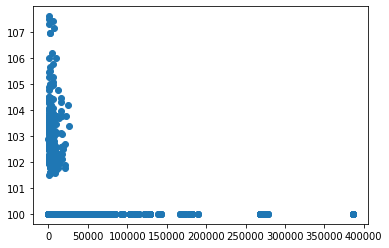

In [85]:
# a quick plot to celebrate that we have data now

import matplotlib.pyplot as plt #graphing module with matlab-like properties
%matplotlib inline 

# datacuts here

datacut= ((finaldata['interest_frequency'] == '2') &
          (finaldata['coupon_change_indicator']=='N') &
          (finaldata['coupon']>0))

# (finaldata['call_price']>100))
          

plt.scatter(finaldata['sale'][datacut],finaldata['call_price'][datacut])

#from scipy.stats import pearsonr
#corr,_=pearsonr(finaldata['sale'][morethan100],finaldata['call_price'][morethan100])


In [127]:
# a few mean tests

# first, is it true that HY don't have make-whole provisions?

# first we need a dummy variable, pandas could make that a touch easier honestly

datafixed=finaldata[datacut]
datanew=pd.get_dummies(datafixed,columns=['make_whole','callable'])
#datafixed=pd.concat([datafixed,datanew], axis=1)

datanew['dscr']=datanew['ebitda']/(datanew['offering_amt']*datanew['coupon']/100)
datanew['dtoy']=datanew['offering_amt']/datanew['ebitda']

# And now mean by groups

#datanew.groupby(['investment_grade'])['make_whole_Y'].mean()
datanew.groupby(['make_whole_Y'])['offering_amt'].mean()

datanew.dropna(subset=['make_whole_Y','offering_amt'],inplace=True)

from scipy.stats import ttest_ind
ttest_ind(*datanew.groupby('make_whole_Y')['offering_amt'].apply(lambda x:list(x)))


Ttest_indResult(statistic=9.320610128576302, pvalue=3.3201817534296544e-20)

In [117]:
# and now a probit
# dependent is make_whole
# independent is sales
# don't work yet because lots of duplicates for some reason

import statsmodels.api as sm
import numpy as np

datalog=datanew.dropna()
X=datalog[['sale']]
# y=np.asarray(dataprob['make_whole_Y'])
#  x=np.asarray(dataprob['sale'])
X=sm.add_constant(X)
y=datalog['make_whole_Y']
model=sm.Logit(y,X)
result = model.fit()
print(result.summary())




Optimization terminated successfully.
         Current function value: 0.016521
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:           make_whole_Y   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1198
Method:                           MLE   Df Model:                            1
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                     inf
Time:                        13:41:01   Log-Likelihood:                -19.825
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9281      0.264     14.882      0.000       3.411       4.445
sale        5.245e-06   5.89e

C:\Users\equintin\.julia\conda\3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\equintin\.julia\conda\3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\equintin\.julia\conda\3\lib\site-packages\statsmodels\discrete\discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
